In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

In [ ]:
# Dataset simulado
df = pd.DataFrame({
    "age": [25, 45, 35, 50, 23],
    "education": ["HS-grad", "Bachelors", "Masters", "HS-grad", "PhD"],
    "income": [25000, 60000, 55000, 80000, 120000]
})

print("=== Dataset original ===")
print(df, "\n")

# 1. Valores categóricos -> OneHot
ohe = OneHotEncoder(sparse_output=False)
encoded = ohe.fit_transform(df[["education"]])
encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(["education"]))

print("=== Variables categóricas codificadas (OneHot) ===")
print(encoded_df, "\n")

# 2. Escalado numérico
scaler = StandardScaler()
scaled = scaler.fit_transform(df[["age", "income"]])
scaled_df = pd.DataFrame(scaled, columns=["age_scaled", "income_scaled"])

print("=== Variables numéricas escaladas (Z-score) ===")
print(scaled_df, "\n")

# 3. Dataset combinado
combined_df = pd.concat([scaled_df, encoded_df], axis=1)
print("=== Dataset combinado listo para ML ===")
print(combined_df, "\n")

# 4. PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(combined_df)
pca_df = pd.DataFrame(pca_features, columns=["PCA1", "PCA2"])

print("=== Resultados tras PCA ===")
print(pca_df, "\n")

# Información adicional sobre varianza explicada
print("Varianza explicada por cada componente PCA:", pca.explained_variance_ratio_)


=== Dataset original ===
   age  education  income
0   25    HS-grad   25000
1   45  Bachelors   60000
2   35    Masters   55000
3   50    HS-grad   80000
4   23        PhD  120000 

=== Variables categóricas codificadas (OneHot) ===
   education_Bachelors  education_HS-grad  education_Masters  education_PhD
0                  0.0                1.0                0.0            0.0
1                  1.0                0.0                0.0            0.0
2                  0.0                0.0                1.0            0.0
3                  0.0                1.0                0.0            0.0
4                  0.0                0.0                0.0            1.0 

=== Variables numéricas escaladas (Z-score) ===
   age_scaled  income_scaled
0       -1.00          -1.37
1        0.88          -0.25
2       -0.06          -0.41
3        1.35           0.38
4       -1.18           1.66 

=== Dataset combinado listo para ML ===
   age_scaled  income_scaled  education_Bach

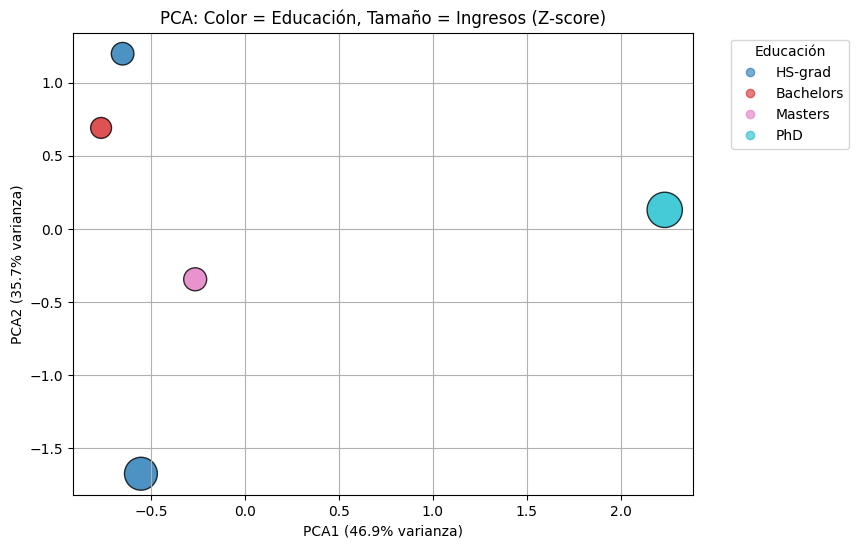

In [6]:
# Usar la versión escalada de income (Z-score) ya calculada en scaled_df
pca_df["income_scaled"] = scaled_df["income_scaled"].values

# Escalar el tamaño de los puntos a partir de income escalado (ajustamos con abs para evitar radios negativos)
plt.figure(figsize=(8,6))

scatter = plt.scatter(
    pca_df["PCA1"], 
    pca_df["PCA2"], 
    c=pd.factorize(pca_df["education"])[0],  # colores según educación
    s=(abs(pca_df["income_scaled"]) + 0.5) * 300,  # tamaño proporcional al income escalado
    cmap="tab10", 
    alpha=0.8, 
    edgecolor="k",
    marker="o"
)

# Leyenda para educación
handles, _ = scatter.legend_elements(prop="colors", alpha=0.6)
edu_labels = list(pca_df["education"].unique())
plt.legend(handles, edu_labels, title="Educación", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.xlabel("PCA1 (46.9% varianza)")
plt.ylabel("PCA2 (35.7% varianza)")
plt.title("PCA: Color = Educación, Tamaño = Ingresos (Z-score)")
plt.grid(True)
plt.show()

## Tratamiento de datos faltantes

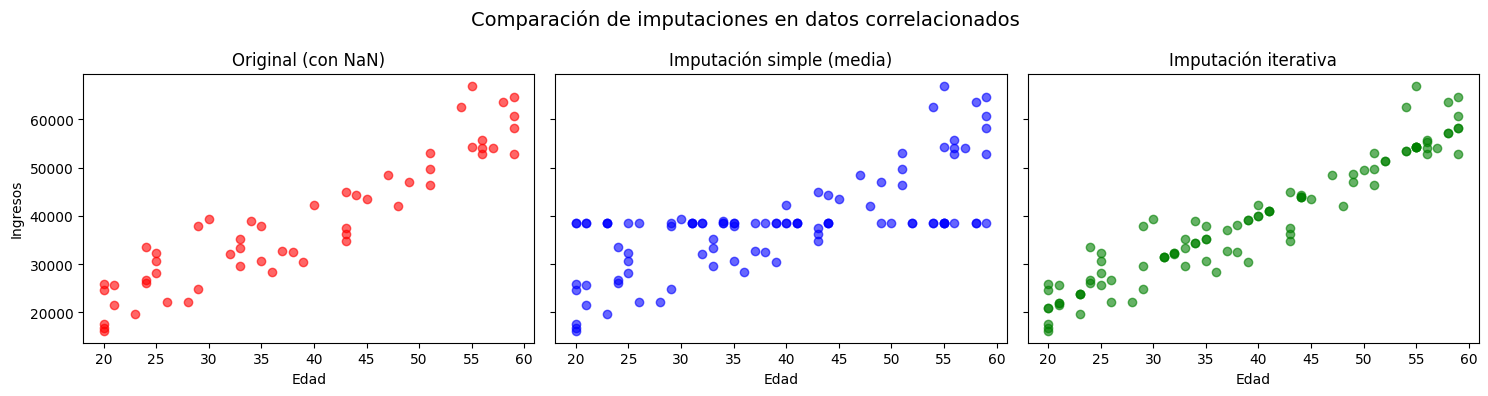

In [11]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

# Simulamos un dataset con correlación clara entre edad e ingresos
np.random.seed(0)
n = 100
edad = np.random.randint(20, 60, size=n)
ingresos = edad * 1000 + np.random.normal(0, 5000, size=n)  # correlación fuerte

df = pd.DataFrame({"edad": edad, "ingresos": ingresos})

# Introducimos valores perdidos artificialmente
df.loc[np.random.choice(df.index, 45, replace=False), "ingresos"] = np.nan

# Imputación simple
df_simple = df.copy()
df_simple["ingresos"] = df_simple["ingresos"].fillna(df["ingresos"].mean())

# Imputación iterativa
imp = IterativeImputer(max_iter=10, random_state=42)
df_iter = df.copy()
df_iter[["edad", "ingresos"]] = imp.fit_transform(df_iter[["edad", "ingresos"]])

# Comparación visual
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

axes[0].scatter(df["edad"], df["ingresos"], color="red", alpha=0.6)
axes[0].set_title("Original (con NaN)")
axes[0].set_xlabel("Edad")
axes[0].set_ylabel("Ingresos")

axes[1].scatter(df_simple["edad"], df_simple["ingresos"], color="blue", alpha=0.6)
axes[1].set_title("Imputación simple (media)")
axes[1].set_xlabel("Edad")

axes[2].scatter(df_iter["edad"], df_iter["ingresos"], color="green", alpha=0.6)
axes[2].set_title("Imputación iterativa")
axes[2].set_xlabel("Edad")

plt.suptitle("Comparación de imputaciones en datos correlacionados", fontsize=14)
plt.tight_layout()
plt.show()


## Tratamiento Outilers

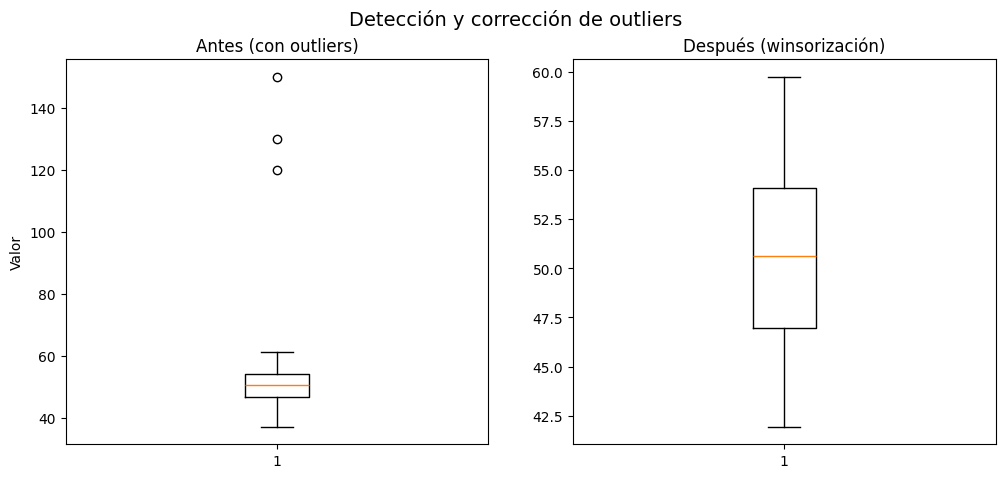

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mstats, zscore

# Dataset con outliers
np.random.seed(0)
data = np.random.normal(50, 5, 100)   # distribución normal
data = np.append(data, [120, 130, 150])  # añadimos outliers
df = pd.DataFrame({"valor": data})

# Winsorización (recorta el 5% en cada cola)
df_winsor = df.copy()
df_winsor["valor"] = mstats.winsorize(df["valor"], limits=[0.05, 0.05])

# Gráfico comparativo
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].boxplot(df["valor"])
axes[0].set_title("Antes (con outliers)")
axes[0].set_ylabel("Valor")

axes[1].boxplot(df_winsor["valor"])
axes[1].set_title("Después (winsorización)")

plt.suptitle("Detección y corrección de outliers", fontsize=14)
plt.show()


## Filtrado de ruido

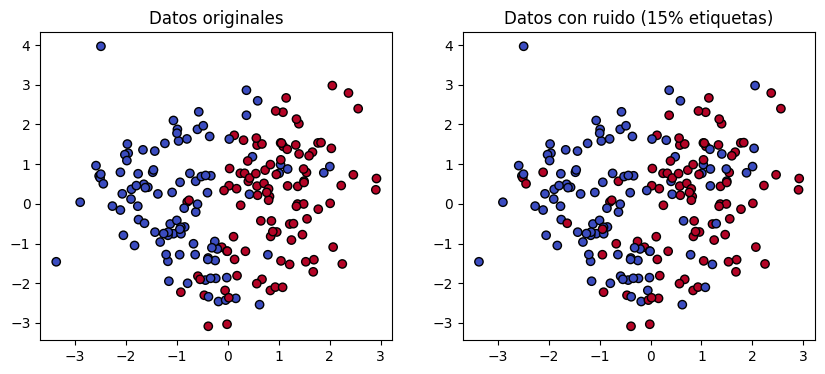

Accuracy sin ruido: 0.94
Accuracy con ruido: 0.90


In [18]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Dataset sencillo
X, y = make_classification(n_samples=200, n_features=2, 
                           n_informative=2, n_redundant=0,
                           random_state=42)

# Introducir ruido en las etiquetas (flip del 15%)
rng = np.random.RandomState(42)
n_noise = int(0.15 * len(y))
noise_idx = rng.choice(len(y), size=n_noise, replace=False)
y_noisy = y.copy()
y_noisy[noise_idx] = 1 - y_noisy[noise_idx]

# Visualización de ruido
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1], c=y, cmap="coolwarm", edgecolor="k")
plt.title("Datos originales")

plt.subplot(1,2,2)
plt.scatter(X[:,0], X[:,1], c=y_noisy, cmap="coolwarm", edgecolor="k")
plt.title("Datos con ruido (15% etiquetas)")
plt.show()

# Comparación de desempeño
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train_noisy, _, y_train_noisy, _ = train_test_split(X, y_noisy, random_state=0)

acc_clean = LogisticRegression().fit(X_train, y_train).score(X_test, y_test)
acc_noisy = LogisticRegression().fit(X_train_noisy, y_train_noisy).score(X_test, y_test)

print(f"Accuracy sin ruido: {acc_clean:.2f}")
print(f"Accuracy con ruido: {acc_noisy:.2f}")


Número de sospechosos detectados: 51
Primeros 10 índices sospechosos: [ 9 13 15 16 23 28 30 36 37 39]


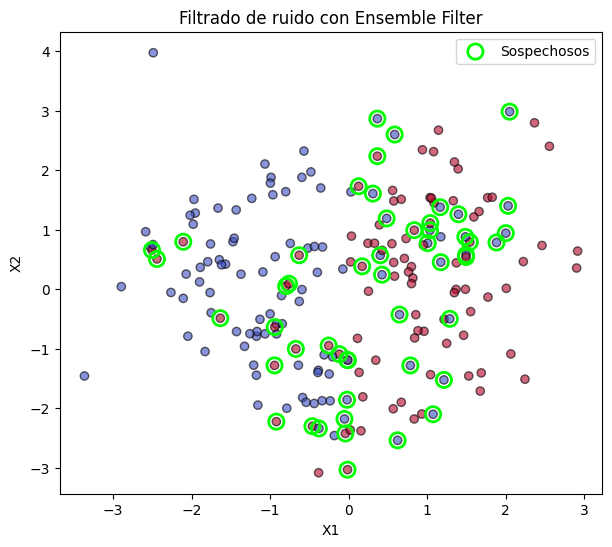

In [14]:
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 2. Ensemble Filter: votación con 3 clasificadores
ensemble = VotingClassifier(
    estimators=[
        ("tree", DecisionTreeClassifier(random_state=0)),
        ("knn", KNeighborsClassifier(n_neighbors=5)),
        ("lda", LinearDiscriminantAnalysis())
    ],
    voting="hard"
)

# 3. Predicciones cruzadas
y_pred = cross_val_predict(ensemble, X, y_noisy, cv=5)

# 4. Identificar posibles ruidosos
suspect_idx = np.where(y_pred != y_noisy)[0]

print("Número de sospechosos detectados:", len(suspect_idx))
print("Primeros 10 índices sospechosos:", suspect_idx[:10])

# Puntos originales con etiquetas ruidosas
plt.figure(figsize=(7,6))
plt.scatter(X[:,0], X[:,1], c=y_noisy, cmap="coolwarm", edgecolor="k", alpha=0.6)

# Resaltar en verde los sospechosos detectados por Ensemble Filter
plt.scatter(X[suspect_idx,0], X[suspect_idx,1], 
            facecolor="none", edgecolor="lime", s=120, linewidth=2, label="Sospechosos")

plt.title("Filtrado de ruido con Ensemble Filter")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.show()

In [24]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
import numpy as np

# 1. Generar dataset
X, y = make_classification(n_samples=400, n_features=2, 
                           n_informative=2, n_redundant=0,
                           random_state=42)

# 2. Introducir ruido en etiquetas
rng = np.random.RandomState(42)
n_noise = int(0.15 * len(y))
noise_idx = rng.choice(len(y), size=n_noise, replace=False)
y_noisy = y.copy()
y_noisy[noise_idx] = 1 - y_noisy[noise_idx]

# 3. Split consistente
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train_noisy, _, y_train_noisy, _ = train_test_split(X, y_noisy, random_state=0)

# 4. Ensemble Filter para detectar sospechosos
ensemble = VotingClassifier(
    estimators=[
        ("tree", DecisionTreeClassifier(random_state=0)),
        ("knn", KNeighborsClassifier(n_neighbors=5)),
        ("lda", LinearDiscriminantAnalysis())
    ],
    voting="hard"
)
y_pred = cross_val_predict(ensemble, X_train_noisy, y_train_noisy, cv=5)
suspect_idx = np.where(y_pred != y_train_noisy)[0]

# 5. Corregimos etiquetas
y_train_corrected = y_train_noisy.copy()
y_train_corrected[suspect_idx] = 1 - y_train_corrected[suspect_idx]

# 6. Logistic Regression con los tres escenarios
acc_clean = LogisticRegression().fit(X_train, y_train).score(X_test, y_test)
acc_noisy = LogisticRegression().fit(X_train_noisy, y_train_noisy).score(X_test, y_test)
acc_corrected = LogisticRegression().fit(X_train_noisy, y_train_corrected).score(X_test, y_test)

print(f"Accuracy sin ruido:      {acc_clean:.2f}")
print(f"Accuracy con ruido:      {acc_noisy:.2f}")
print(f"Accuracy tras corrección:{acc_corrected:.2f}")


Accuracy sin ruido:      0.93
Accuracy con ruido:      0.91
Accuracy tras corrección:0.92


## Normalización de datos

Accuracy KNN sin escalar: 0.650
Accuracy KNN Min-Max:     0.900
Accuracy KNN Z-score:     0.883


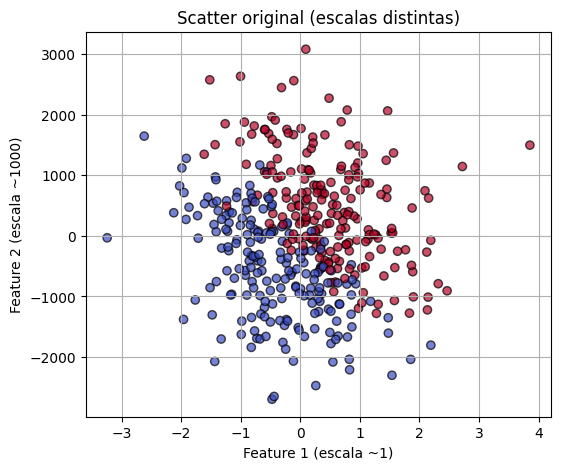

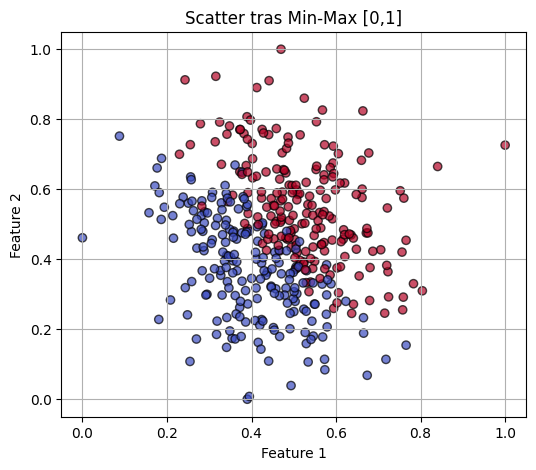

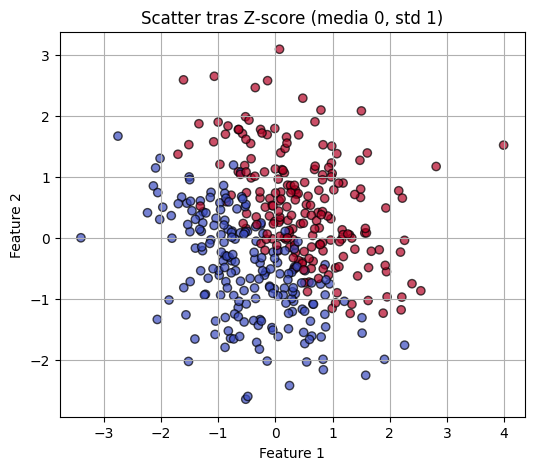

In [27]:
# Demostración donde ESCALAR SÍ importa para KNN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

rng = np.random.RandomState(42)
n = 400

# Dos features con distinta escala
x1 = rng.normal(0, 1, size=n)          # escala pequeña (p.ej., metros)
x2 = rng.normal(0, 1000, size=n)       # escala grande (p.ej., euros)

# Etiquetas dependen de AMBAS features (misma importancia real)
noise = rng.normal(0, 0.4, size=n)
y = ((x1 + (x2/1000) + noise) > 0).astype(int)

X = np.c_[x1, x2]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# KNN SIN escalar
knn_raw = KNeighborsClassifier(n_neighbors=7)
acc_raw = accuracy_score(y_test, knn_raw.fit(X_train, y_train).predict(X_test))

# KNN con Min-Max (pipeline para evitar leakage)
knn_mm = make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=7))
acc_mm = accuracy_score(y_test, knn_mm.fit(X_train, y_train).predict(X_test))

# KNN con Z-score (pipeline)
knn_z = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=7))
acc_z = accuracy_score(y_test, knn_z.fit(X_train, y_train).predict(X_test))

print(f"Accuracy KNN sin escalar: {acc_raw:.3f}")
print(f"Accuracy KNN Min-Max:     {acc_mm:.3f}")
print(f"Accuracy KNN Z-score:     {acc_z:.3f}")

# --- Gráficos (una figura por gráfico, sin seaborn) ---
# Original
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c=y, cmap="coolwarm", edgecolor="k", alpha=0.7)
plt.title("Scatter original (escalas distintas)")
plt.xlabel("Feature 1 (escala ~1)")
plt.ylabel("Feature 2 (escala ~1000)")
plt.grid(True)
plt.show()

# Min-Max
X_mm = MinMaxScaler().fit_transform(X)
plt.figure(figsize=(6,5))
plt.scatter(X_mm[:,0], X_mm[:,1], c=y, cmap="coolwarm", edgecolor="k", alpha=0.7)
plt.title("Scatter tras Min-Max [0,1]")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

# Z-score
X_z = StandardScaler().fit_transform(X)
plt.figure(figsize=(6,5))
plt.scatter(X_z[:,0], X_z[:,1], c=y, cmap="coolwarm", edgecolor="k", alpha=0.7)
plt.title("Scatter tras Z-score (media 0, std 1)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()


## Transformación del rango

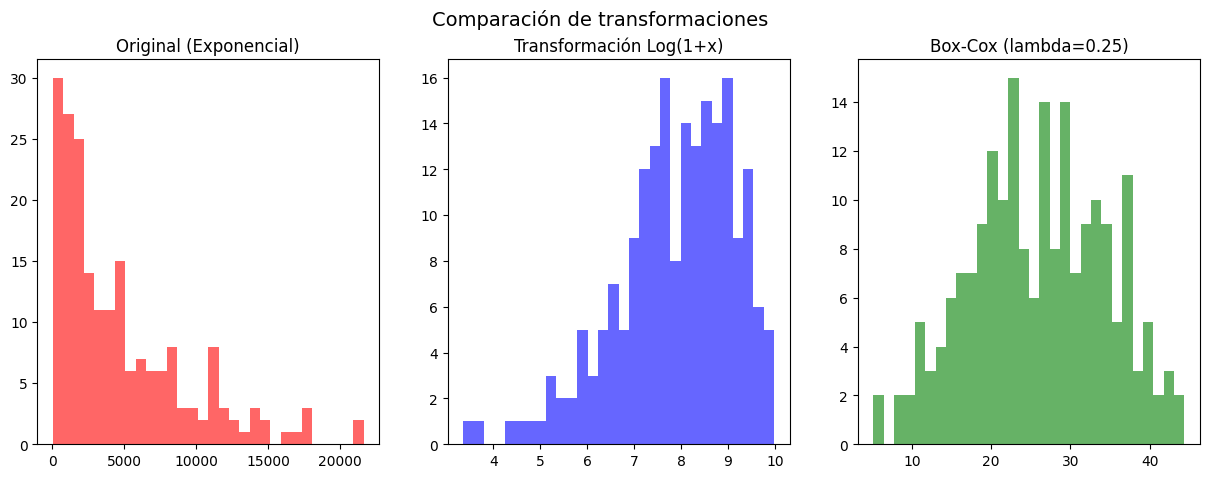

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Simular datos sesgados (distribución exponencial)
np.random.seed(42)
data = np.random.exponential(scale=5000, size=200)
df = pd.DataFrame({"ingresos": data})

# Log-transform
df["ingresos_log"] = np.log1p(df["ingresos"])  # log(1+x) para evitar log(0)

# Box-Cox (requiere datos positivos)
fitted_data, fitted_lambda = stats.boxcox(df["ingresos"])

# Gráficos
fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].hist(df["ingresos"], bins=30, color="red", alpha=0.6)
axes[0].set_title("Original (Exponencial)")
axes[1].hist(df["ingresos_log"], bins=30, color="blue", alpha=0.6)
axes[1].set_title("Transformación Log(1+x)")
axes[2].hist(fitted_data, bins=30, color="green", alpha=0.6)
axes[2].set_title(f"Box-Cox (lambda={fitted_lambda:.2f})")
plt.suptitle("Comparación de transformaciones", fontsize=14)
plt.show()


In [30]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Dataset simulado
df = pd.DataFrame({
    "educacion": ["Secundaria", "Universidad", "Doctorado", "Secundaria", "Universidad"]
})

print("=== Datos originales ===")
print(df, "\n")

# Label Encoding (ordinal)
le = LabelEncoder()
df["educacion_label"] = le.fit_transform(df["educacion"])

print("=== Label Encoding ===")
print(df, "\n")

# One-Hot Encoding
ohe = OneHotEncoder(sparse_output=False)
encoded = ohe.fit_transform(df[["educacion"]])
df_ohe = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(["educacion"]))

print("=== One-Hot Encoding ===")
print(pd.concat([df, df_ohe], axis=1))


=== Datos originales ===
     educacion
0   Secundaria
1  Universidad
2    Doctorado
3   Secundaria
4  Universidad 

=== Label Encoding ===
     educacion  educacion_label
0   Secundaria                1
1  Universidad                2
2    Doctorado                0
3   Secundaria                1
4  Universidad                2 

=== One-Hot Encoding ===
     educacion  educacion_label  educacion_Doctorado  educacion_Secundaria  \
0   Secundaria                1                  0.0                   1.0   
1  Universidad                2                  0.0                   0.0   
2    Doctorado                0                  1.0                   0.0   
3   Secundaria                1                  0.0                   1.0   
4  Universidad                2                  0.0                   0.0   

   educacion_Universidad  
0                    0.0  
1                    1.0  
2                    0.0  
3                    0.0  
4                    1.0  


In [32]:
from sklearn.feature_extraction import FeatureHasher
import pandas as pd

df = pd.DataFrame({"producto": ["A123", "B456", "C789", "D321", "E654"]})

# Cada fila como lista con un solo token
samples = df["producto"].apply(lambda s: [s]).tolist()

h = FeatureHasher(n_features=4, input_type="string")
X = h.transform(samples)           # matriz dispersa
df_hashed = pd.DataFrame(X.toarray())
print(df_hashed)



     0    1    2    3
0 -1.0  0.0  0.0  0.0
1  0.0  1.0  0.0  0.0
2  0.0  0.0  1.0  0.0
3  0.0  0.0  0.0 -1.0
4  0.0  0.0  1.0  0.0


In [33]:
from sklearn.feature_extraction.text import HashingVectorizer

docs = ["me gusta el hash", "hash de características", "texto con tokens"]
vec = HashingVectorizer(n_features=8, alternate_sign=False, ngram_range=(1,1), binary=True)
X = vec.transform(docs)
print(X.toarray())


[[0.577 0.577 0.    0.577 0.    0.    0.    0.   ]
 [0.    0.    0.    0.707 0.    0.    0.707 0.   ]
 [0.    0.577 0.    0.577 0.577 0.    0.    0.   ]]


In [34]:
import pandas as pd
import numpy as np

df = pd.DataFrame({"edad": [18, 22, 35, 47, 59, 70, 85]})

# Definir intervalos
bins = [0, 29, 59, 100]
labels = ["Joven", "Adulto", "Senior"]

df["edad_binned"] = pd.cut(df["edad"], bins=bins, labels=labels)
print(df)


   edad edad_binned
0    18       Joven
1    22       Joven
2    35      Adulto
3    47      Adulto
4    59      Adulto
5    70      Senior
6    85      Senior
